<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/GNMR2023/R1p.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# $R_{1\rho}$ Relaxation

In [ ]:
!git clone https://github.com/alsinmr/ConferenceExamples.git
%cd /content/ConferenceExamples/GNMR2023
import setup

In [ ]:
#Sometimes, there is a delay between setup finishing and being able to complete the module loads
from importlib.machinery import SourceFileLoader #Why do I need to use this instead of a simple import?
RS = SourceFileLoader("pyRelaxSim", "/content/pyRelaxSim/__init__.py").load_module()  
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
import SLEEPY as RS
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib notebook

## Build the system
In this example, we first look at $R_{1\rho}$ relaxation due to reorienation of a dipole coupling and CSA (typical for $^{15}$N)

In [12]:
ex0=RS.ExpSys(v0H=850,Nucs=['15N','1H'],vr=45000,pwdavg=RS.PowderAvg(q=3))
ex1=ex0.copy()
delta=RS.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
# ex0.set_inter('CSA',i=0,delta=150,euler=[0,15*np.pi/180,0])
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,10*np.pi/180,0])
# ex1.set_inter('CSA',i=0,delta=150,euler=[[0,15*np.pi/180,0],[0,30*np.pi/180,0]])

## Add the exchange process (symmetric exchange)
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. Here we start assuming the populations, $p_1$ and $p_2$ are equal.

In [24]:
L=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-6     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1)

## Monitor the decay under a spin-lock
We have to define a sequence to include RF fields. In this case, we'll just take default behavior which is to apply a continuous field for one rotor cycle.

In [14]:
t0=time()
seq=L.Sequence()
seq.add_channel('15N',v1=25000)
U=seq.U()**50    #Take 50 rotor periods at a time (50/45000=1.11 ms)

rho=RS.Rho(rho0='15Nx',detect='15Nx')
_=rho.DetProp(U,n=200)
print(f"Total time was {time()-t0:.1f} s")

Total time was 2.8 s


Plot the results for a simple $R_{1\rho}$ experiment

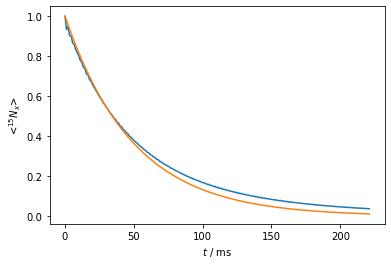

In [15]:
ax=rho.plot(axis='ms')
t=rho.t_axis
rho.reset()
R=rho.extract_decay_rates(seq.U(),pwdavg=True)
ax.plot(t*1e3,np.exp(-t*R))

## Observe behavior as a function of spin-lock strength
We start out with a relatively fast motion, with symmetric exchange

v1=10000, R1p=20.4
v1=15000, R1p=20.4
v1=20000, R1p=20.3
v1=25000, R1p=20.2
v1=30000, R1p=20.0
v1=35000, R1p=19.8
v1=40000, R1p=19.0
Total time was 19.2 s


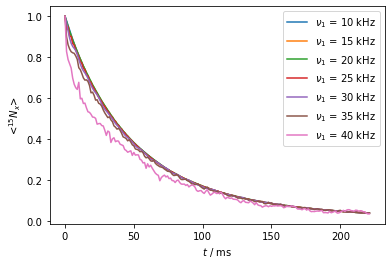

In [16]:
tc=1e-6     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1)

t0=time()
v10=np.linspace(10000,40000,7)  #Every 5 kHz
ax=plt.subplots()[1]
for v1 in v10:
    seq.add_channel('15N',v1=v1)
    U=seq.U()
    rho.clear()
    print(f'v1={v1:.0f}, R1p={rho.extract_decay_rates(U,pwdavg=True,reweight=False):.1f}')
    U=U**50
    rho.DetProp(U,n=200)
    rho.plot(ax=ax)
ax.legend([r'$\nu_1$'+f' = {v1/1e3:.0f} kHz' for v1 in v10])
print(f'Total time was {time()-t0:.1f} s')

## Monitor behavior for slow motion
Now, we replace the exchange rate to see the response to changing $\nu_1$ for slow motion

v1=10000, R1p=2.5
v1=15000, R1p=3.0
v1=20000, R1p=3.9
v1=25000, R1p=5.6
v1=30000, R1p=9.2
v1=35000, R1p=18.8
v1=40000, R1p=59.1
Total time was 17.6 s


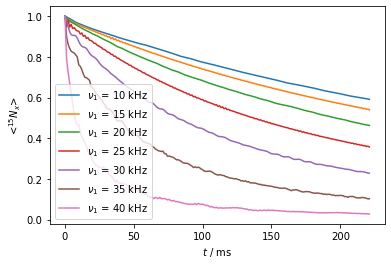

In [17]:
tc=1e-4     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

t0=time()
v10=np.linspace(10000,40000,7)  #Every 5 kHz
ax=plt.subplots()[1]
for v1 in v10:
    seq.add_channel('15N',v1=v1)
    U=seq.U()
    rho.clear()
    print(f'v1={v1:.0f}, R1p={rho.extract_decay_rates(U,pwdavg=True):.1f}')
    U=U**50
    rho.DetProp(U,n=200)
    rho.plot(ax=ax)
ax.legend([r'$\nu_1$'+f' = {v1/1e3:.0f} kHz' for v1 in v10])
print(f'Total time was {time()-t0:.1f} s')

We see a relaxation-dispersion effect for the slow motion

## Find $R_{1\rho}$ profiles for various correlation times
Here, we sweep both $\nu_1$ and $\tau_c$. We use a function that extracts the mean relaxation rate constants from rho directly, rather than fitting the decay curves.

In [11]:
t0=time()
tc0=np.logspace(-7,-3,9)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

v10=np.linspace(10000,35000,11)  #Every 2.5 kHz
R1p=np.zeros([tc0.size,v10.size])
for k,tc in enumerate(tc0):
    L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1)
    
    for m,v1 in enumerate(v10):
        rho.clear()
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        R1p[k,m]=rho.extract_decay_rates(U,pwdavg=True,reweight=False)

print(f'Total time was {time()-t0:.1f} s')

Total time was 258.4 s


Plot the results

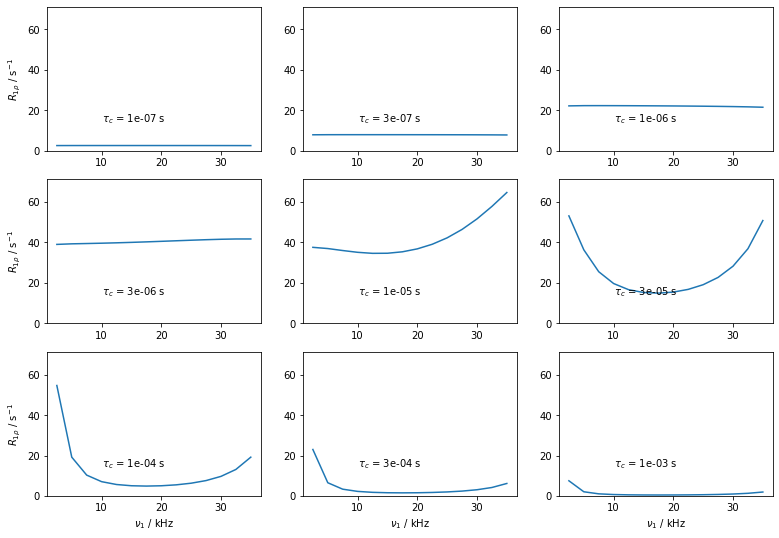

In [22]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches([13,9])
ax=ax.reshape(ax.size)

for R1p0,tc,a in zip(R1p,tc0,ax):
    a.plot(v10/1e3,R1p0)
    if a.is_last_row():
        a.set_xlabel(r'$\nu_1$ / kHz')
    if a.is_first_col():
        a.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')
    a.set_ylim([0,R1p.max()*1.1])
    a.text(10,a.get_ylim()[1]*.2,r'$\tau_c$'+f' = {tc:.0e} s')
    

## Inclusion of BMRD (chemical exchange) relaxation
We also add modulation of the chemical shift and re-calculate the above profiles

In [18]:
ex0.set_inter('CS',i=0,ppm=0)  #Add modulation of the chemical shift
ex1.set_inter('CS',i=0,ppm=5)

L=RS.Liouvillian((ex0,ex1))
seq=L.Sequence()

#Re-run the calculation
t0=time()
tc0=np.logspace(-7,-3,9)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

v10=np.concatenate(([2500,5000,7500],np.linspace(10000,35000,11)))  #Every 2.5 kHz
R1p=np.zeros([tc0.size,v10.size])
for k,tc in enumerate(tc0):
    kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
        np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
    L.kex=kex
    
    for m,v1 in enumerate(v10):
        rho.clear()
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        R1p[k,m]=rho.extract_decay_rates(U,pwdavg=True,reweight=False)
        #Decay rate is approximately the loss after one point divided by the time elapsed

print(time()-t0)

364.6342179775238


Plot the results

In [25]:
1+3/4*(np.cos(10*np.pi/180)**2-1)

0.9773847327947156

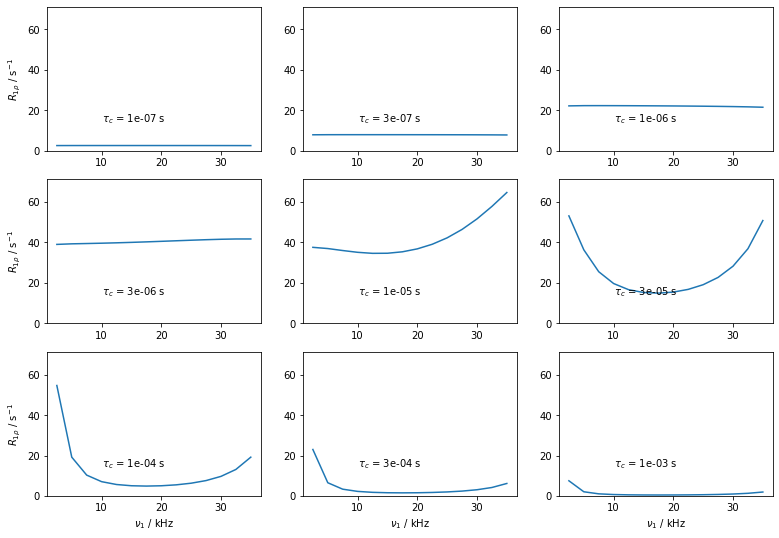

In [23]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches([13,9])
ax=ax.reshape(ax.size)

for R1p0,tc,a in zip(R1p,tc0,ax):
    a.plot(v10/1e3,R1p0)
    if a.is_last_row():
        a.set_xlabel(r'$\nu_1$ / kHz')
    if a.is_first_col():
        a.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')
    a.set_ylim([0,R1p.max()*1.1])
    a.text(10,a.get_ylim()[1]*.2,r'$\tau_c$'+f' = {tc:.0e} s')

## Separating population from hop angle/CS change
For fast motion, it is not possible to separate the influence of populations of the two states from amplitudes of motion or from the change in chemical shift. For example, for NERRD relaxation, relaxation rate constants are proportional to $(1–S^2)$, where $S^2$ is given by

$S^2=1+3p_1p_2(\cos^2(\theta)-1)$

Then, we cannot separate $\theta$ from the populations, $p_1$ and $p_2$. On the other hand, for fast motion, BMRD relaxation is proportional to

$p_1p_2(\Delta\Omega)^2$

which similarly does not allow us to separate the populations. For example, consider two systems with the same values for $S^2$ and for $p_1p_2(\Delta\Omega)^2$

Below, we take a relatively fast motion and show that all curves are identical for fixed values of $S^2$ and $p_1p_2(\Delta\Omega)^2$, independent of the values of $p_1$ and $p_2$

In [62]:
hop_angle=15
DeltaCS=5
tc=5e-5     #Correlation time
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2
S2=3*p1*p2*(np.cos(hop_angle*np.pi/180)**2-1)+1
p1p2DelCS2=p1*p2*DeltaCS**2
print(f'S2 for system 1 is {S2:.3f}')
print(f'p1*p2*Delta(CS)^2 for system 1 is {p1p2DelCS2:.3f}')

ex0=RS.ExpSys(v0H=850,Nucs=['15N','1H'],vr=45000)
ex1=ex0.copy()
delta=RS.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=150,euler=[0,15*np.pi/180,0])
ex0.set_inter('CS',i=0,ppm=0)
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,hop_angle*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=150,euler=[[0,15*np.pi/180,0],[0,hop_angle*np.pi/180,0]])
ex1.set_inter('CS',i=0,ppm=DeltaCS)

L1=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))

L1.kex=kex
d,v=np.linalg.eig(kex)
print(f'tc for system 1 is {-1/d.min():.1e} s\n')

p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2
hop_angle=np.arccos(np.sqrt((S2-1)/(3*p1*p2)+1))*180/np.pi
DeltaCS=np.sqrt(p1p2DelCS2/(p1*p2))

S2=3*p1*p2*(np.cos(hop_angle*np.pi/180)**2-1)+1
p1p2DelCS2=p1*p2*DeltaCS**2
print(f'S2 for system 2 is {S2:.3f}')
print(f'p1*p2*Delta(CS)^2 for system 2 is {p1p2DelCS2:.3f}')


ex0=RS.ExpSys(v0H=850,Nucs=['15N','1H'],vr=45000)
ex1=ex0.copy()
delta=RS.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=150,euler=[0,15*np.pi/180,0])
ex0.set_inter('CS',i=0,ppm=0)
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,hop_angle*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=150,euler=[[0,15*np.pi/180,0],[0,hop_angle*np.pi/180,0]])
ex1.set_inter('CS',i=0,ppm=DeltaCS)

L2=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L2.kex=kex

print(f'tc for system 2 is {-1/d.min():.1e} s')

S2 for system 1 is 0.950
p1*p2*Delta(CS)^2 for system 1 is 6.250
tc for system 1 is 5.0e-05 s

S2 for system 2 is 0.950
p1*p2*Delta(CS)^2 for system 2 is 6.250
tc for system 2 is 5.0e-05 s


v1=2500, R1p=78.6
v1=5000, R1p=49.3
v1=10000, R1p=33.5
v1=15000, R1p=33.4
v1=20000, R1p=39.6
v1=25000, R1p=53.0
v1=30000, R1p=80.0
v1=35000, R1p=139.2
Total time was 19.9 s
v1=2500, R1p=78.5
v1=5000, R1p=49.2
v1=10000, R1p=33.4
v1=15000, R1p=33.3
v1=20000, R1p=39.5
v1=25000, R1p=52.8
v1=30000, R1p=79.5
v1=35000, R1p=137.4
Total time was 21.3 s


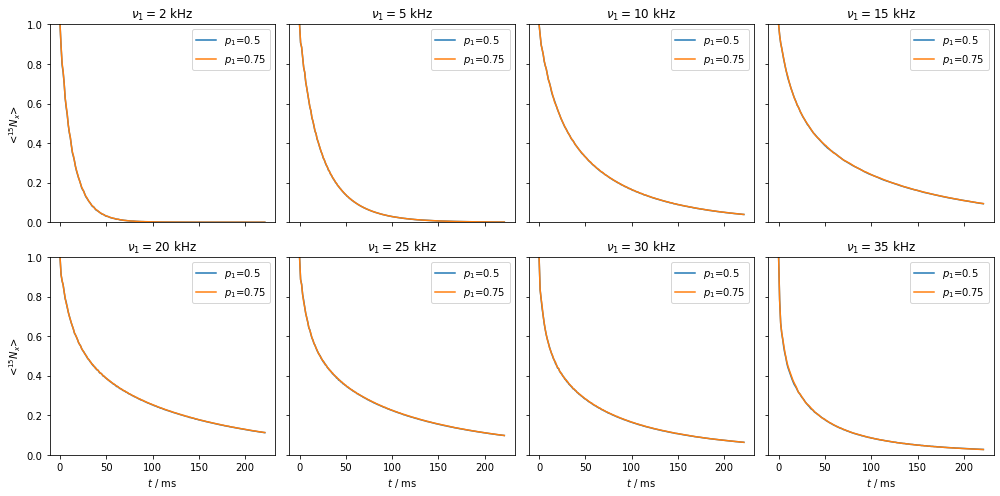

In [63]:
v10=[2500,5000,10000,15000,20000,25000,30000,35000]
fig,ax=plt.subplots(2,len(v10)//2)
ax=ax.flatten()
fig.set_size_inches([14,7])
for L in [L1,L2]:
    seq=L.Sequence()
    t0=time()
    
    for v1,a in zip(v10,ax):
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        rho.clear()
        print(f'v1={v1:.0f}, R1p={rho.extract_decay_rates(U,pwdavg=True):.1f}')
        U=U**50
        rho.DetProp(U,n=200)
        rho.plot(ax=a)
        a.set_title(r'$\nu_1 = $'+f'{v1/1e3:.0f} kHz')
        a.legend((r'$p_1$=0.5',r'$p_1$=0.75'))
        if not(a.is_first_col()):
            a.set_ylabel('')
            a.set_yticklabels('')
        if not(a.is_last_row()):
            a.set_xlabel('')
            a.set_xticklabels('')
        a.set_ylim([0,1])
    print(f'Total time was {time()-t0:.1f} s')
fig.tight_layout()

As expected, all relaxation curves are the same despite the different populations, showing the inseparability of $p_1p_2$ from $\theta_{12}$ and from $\Delta\Omega_{12}$

What happens if we have a slower motion?

v1=250, R1p=6.0
v1=500, R1p=2.5
v1=1000, R1p=0.9
v1=2500, R1p=0.2
v1=5000, R1p=0.1
v1=10000, R1p=0.0
v1=20000, R1p=0.0
v1=35000, R1p=0.1
Total time was 23.4 s
v1=250, R1p=3.7
v1=500, R1p=2.1
v1=1000, R1p=0.8
v1=2500, R1p=0.2
v1=5000, R1p=0.1
v1=10000, R1p=0.0
v1=20000, R1p=0.0
v1=35000, R1p=0.1
Total time was 21.4 s


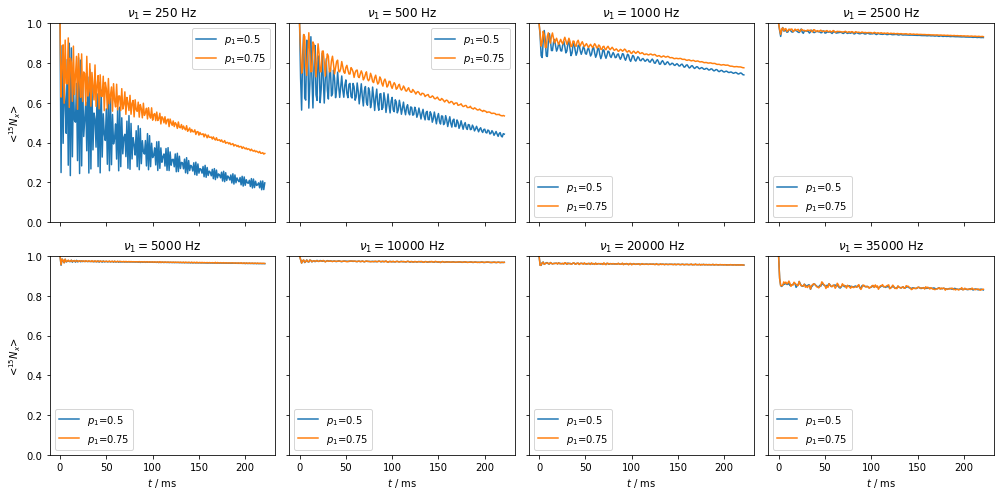

In [64]:
tc=5e-2     #Correlation time
L1.kex=RS.Tools.twoSite_kex(tc=tc,p1=0.5)
L2.kex=RS.Tools.twoSite_kex(tc=tc,p1=0.75)

v10=[250,500,1000,2500,5000,10000,20000,35000]
fig,ax=plt.subplots(2,len(v10)//2)
ax=ax.flatten()
fig.set_size_inches([14,7])
for L in [L1,L2]:
    seq=L.Sequence()
    t0=time()
    
    for v1,a in zip(v10,ax):
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        rho.clear()
        print(f'v1={v1:.0f}, R1p={rho.extract_decay_rates(U,pwdavg=True):.1f}')
        U=U**50
        rho.DetProp(U,n=200)
        rho.plot(ax=a)
        a.set_title(r'$\nu_1 = $'+f'{v1:.0f} Hz')
        a.legend((r'$p_1$=0.5',r'$p_1$=0.75'))
        if not(a.is_first_col()):
            a.set_ylabel('')
            a.set_yticklabels('')
        if not(a.is_last_row()):
            a.set_xlabel('')
            a.set_xticklabels('')
        a.set_ylim([0,1])
    print(f'Total time was {time()-t0:.1f} s')
fig.tight_layout()